In [1]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [2]:
# PostgreSQL connection setup
conn = psycopg2.connect(
    dbname="movie_data",
    user="postgres",
    password="mlip-007",
    host="localhost",
    port="5432"
)
cursor = conn.cursor()

In [3]:
# Load user metadata
def load_user_metadata():
    query = """
    SELECT user_id, age, gender
    FROM users
    WHERE age IS NOT NULL AND gender IS NOT NULL
    """
    cursor.execute(query)
    data = cursor.fetchall()
    return pd.DataFrame(data, columns=['user_id', 'age', 'gender'])

# Load movie metadata
def load_movie_metadata():
    query = """
    SELECT movie_id, genres
    FROM movies
    WHERE genres IS NOT NULL
    """
    cursor.execute(query)
    data = cursor.fetchall()
    return pd.DataFrame(data, columns=['movie_id', 'genres'])


user_metadata = load_user_metadata()
movie_metadata = load_movie_metadata()

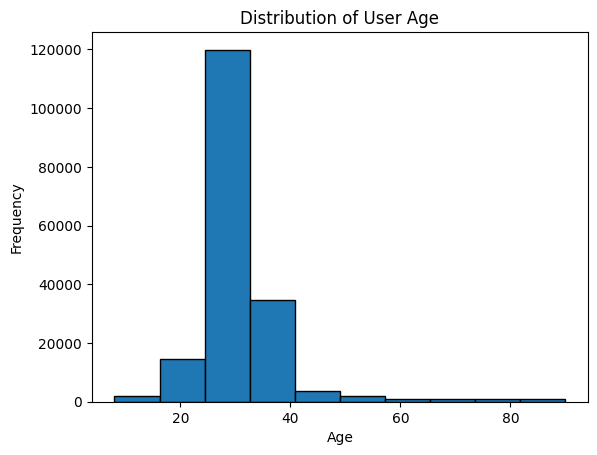

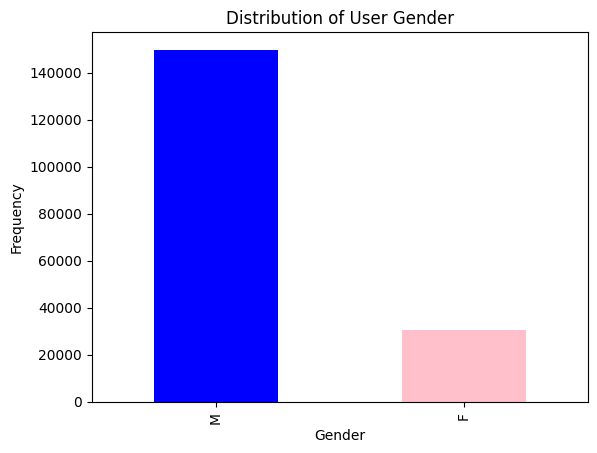

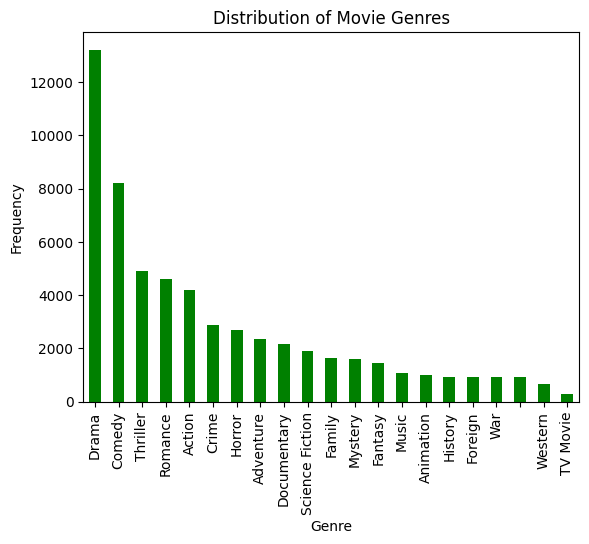

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

# Test data distribution
def test_data_distribution(user_metadata, movie_metadata):
    # Distribution of user age
    plt.hist(user_metadata['age'], bins=10, edgecolor='black')
    plt.title("Distribution of User Age")
    plt.xlabel("Age")
    plt.ylabel("Frequency")
    plt.show()

    # Distribution of user gender
    gender_counts = user_metadata['gender'].value_counts()
    gender_counts.plot(kind='bar', color=['blue', 'pink'])
    plt.title("Distribution of User Gender")
    plt.xlabel("Gender")
    plt.ylabel("Frequency")
    plt.show()

    # Distribution of movie genres
    genre_counts = movie_metadata['genres'].str.split(", ").explode().value_counts()
    genre_counts.plot(kind='bar', color='green')
    plt.title("Distribution of Movie Genres")
    plt.xlabel("Genre")
    plt.ylabel("Frequency")
    plt.show()

# Evaluate RMSE for different groups
def evaluate_rmse_by_group(predictions, actual_ratings, user_metadata, movie_metadata):
    # Merge predictions with actual ratings
    merged = predictions.merge(actual_ratings, on=['user_id', 'movie_id'], suffixes=('_predicted', '_actual'))
    
    # Merge with user metadata
    merged = merged.merge(user_metadata, on='user_id', how='left')
    
    # Merge with movie metadata
    merged = merged.merge(movie_metadata, on='movie_id', how='left')
    
    # RMSE by gender
    print("RMSE by Gender:")
    for gender in merged['gender'].unique():
        group_data = merged[merged['gender'] == gender]
        rmse = sqrt(mean_squared_error(group_data['rating_actual'], group_data['predicted_rating']))
        print(f"Gender: {gender}, RMSE: {rmse:.4f}")
    
    # RMSE by age group
    print("\nRMSE by Age Group:")
    merged['age_group'] = pd.cut(merged['age'], bins=[0, 18, 35, 50, 100], labels=['<18', '18-35', '35-50', '50+'])
    for age_group in merged['age_group'].unique():
        group_data = merged[merged['age_group'] == age_group]
        rmse = sqrt(mean_squared_error(group_data['rating_actual'], group_data['predicted_rating']))
        print(f"Age Group: {age_group}, RMSE: {rmse:.4f}")
    
    # RMSE by genre
    print("\nRMSE by Genre:")
    genre_rmse = {}
    for _, row in merged.iterrows():
        genres = row['genres'].split(", ")
        for genre in genres:
            if genre not in genre_rmse:
                genre_rmse[genre] = {'y_true': [], 'y_pred': []}
            genre_rmse[genre]['y_true'].append(row['rating_actual'])
            genre_rmse[genre]['y_pred'].append(row['predicted_rating'])
    
    for genre, data in genre_rmse.items():
        rmse = sqrt(mean_squared_error(data['y_true'], data['y_pred']))
        print(f"Genre: {genre}, RMSE: {rmse:.4f}")

# Load actual ratings
def load_actual_ratings():
    query = """
    SELECT user_id, movie_id, rating
    FROM user_ratings
    """
    cursor.execute(query)
    data = cursor.fetchall()
    return pd.DataFrame(data, columns=['user_id', 'movie_id', 'rating'])

# Main analysis
actual_ratings = load_actual_ratings()

# Test data distribution
test_data_distribution(user_metadata, movie_metadata)



/tmp/ipykernel_2575471/2478467867.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=gender_rmse_df, x='Gender', y='RMSE', palette='viridis')


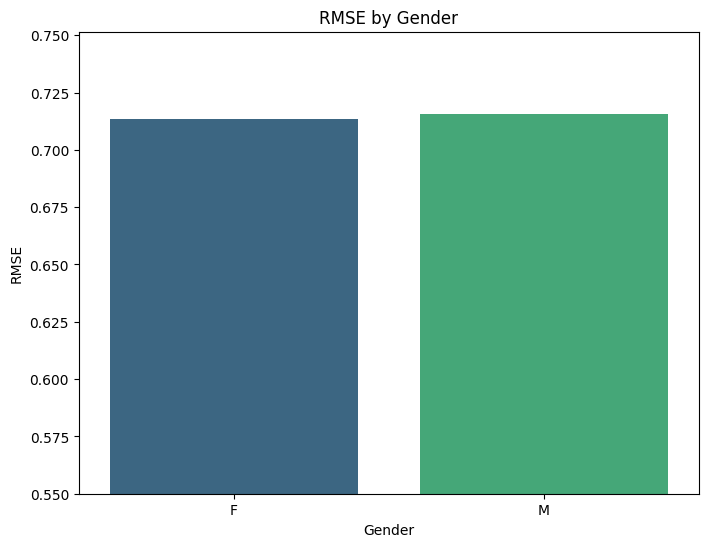

/tmp/ipykernel_2575471/2478467867.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=age_group_rmse_df, x='Age Group', y='RMSE', palette='coolwarm')


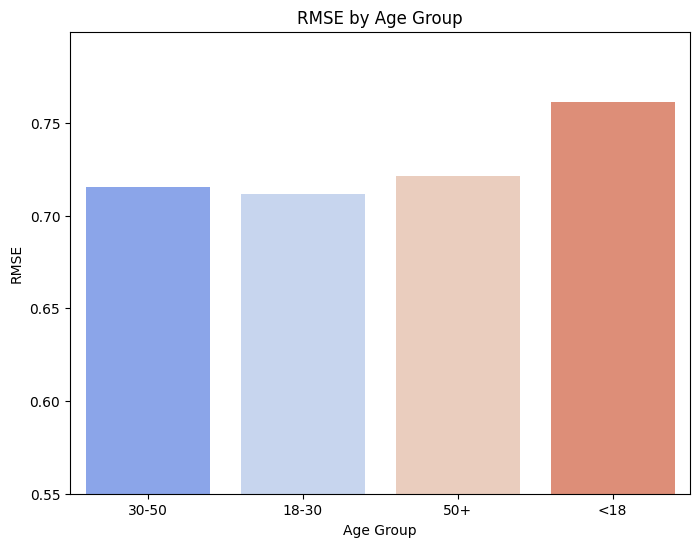

/tmp/ipykernel_2575471/2478467867.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=genre_rmse_df, x='Genre', y='RMSE', palette='magma')


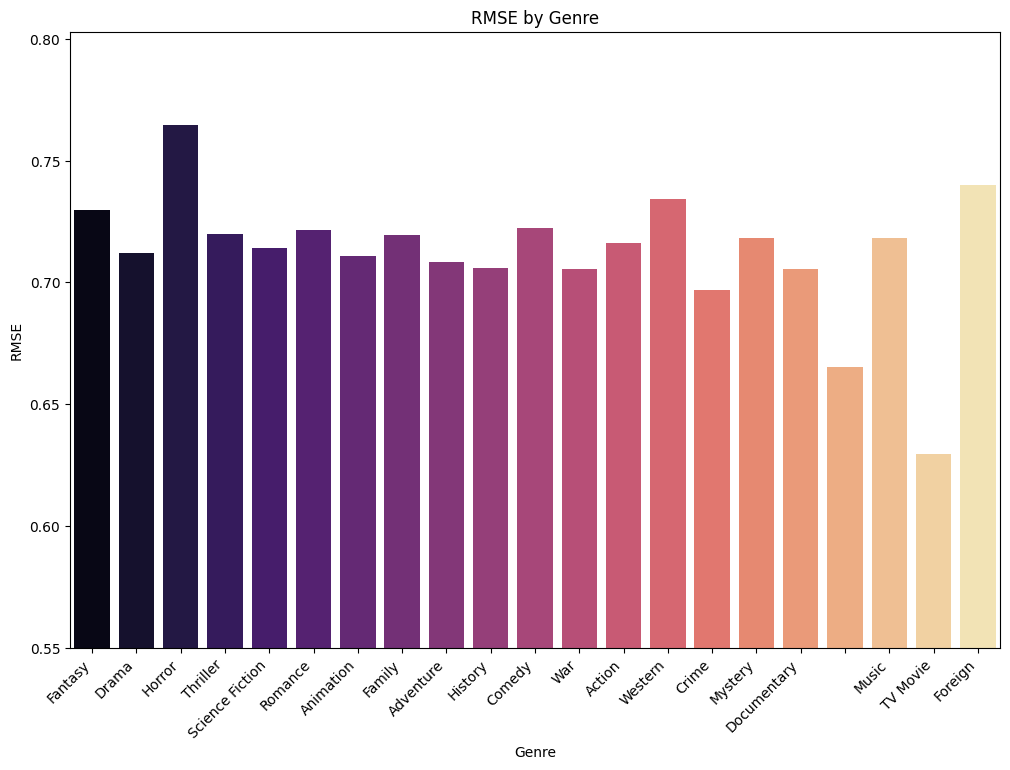

In [5]:
# Evaluate RMSE by groupfrom sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
import pickle
from ML.SVDCFModel import SVDCFModel
import seaborn as sns

# Load the trained recommendation model
def load_model(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    return model

def predict_actual_ratings(model, actual_ratings):
    """Generate predictions for user-item pairs in actual_ratings."""
    predictions = []
    for _, row in actual_ratings.iterrows():
        predicted_rating = model.predict(row['user_id'], row['movie_id'])
        predictions.append({
            'user_id': row['user_id'],
            'movie_id': row['movie_id'],
            'predicted_rating': predicted_rating
        })
    return pd.DataFrame(predictions)
# Evaluate RMSE for different groups
def evaluate_rmse_by_group(predictions, actual_ratings, user_metadata, movie_metadata):
    # Merge predictions with actual ratings
    merged = predictions.merge(actual_ratings, on=['user_id', 'movie_id'], suffixes=('_predicted', '_actual'))
    
    # Merge with user metadata
    merged = merged.merge(user_metadata, on='user_id', how='left')
    
    # Merge with movie metadata
    merged = merged.merge(movie_metadata, on='movie_id', how='left')

    merged['rating'] = pd.to_numeric(merged['rating'], errors='coerce')
    merged['predicted_rating'] = pd.to_numeric(merged['predicted_rating'], errors='coerce')

    # Drop rows with NaN values in rating or predicted_rating
    merged = merged.dropna(subset=['rating', 'predicted_rating'])
    
    # RMSE by gender
    gender_rmse = []
    for gender in merged['gender'].unique():
        group_data = merged[merged['gender'] == gender]
        rmse = sqrt(mean_squared_error(group_data['rating'], group_data['predicted_rating']))
        gender_rmse.append({'Gender': gender, 'RMSE': rmse})
    
    gender_rmse_df = pd.DataFrame(gender_rmse)
    plt.figure(figsize=(8, 6))
    sns.barplot(data=gender_rmse_df, x='Gender', y='RMSE', palette='viridis')
    plt.title('RMSE by Gender')
    plt.xlabel('Gender')
    plt.ylabel('RMSE')
    plt.ylim(0.55, None)
    plt.show()
    
    # RMSE by age group
    merged['age_group'] = pd.cut(merged['age'], bins=[0, 18, 30, 50, 100], labels=['<18', '18-30', '30-50', '50+'])
    age_group_rmse = []
    for age_group in merged['age_group'].unique():
        group_data = merged[merged['age_group'] == age_group]
        rmse = sqrt(mean_squared_error(group_data['rating'], group_data['predicted_rating']))
        age_group_rmse.append({'Age Group': age_group, 'RMSE': rmse})
    
    age_group_rmse_df = pd.DataFrame(age_group_rmse)
    plt.figure(figsize=(8, 6))
    sns.barplot(data=age_group_rmse_df, x='Age Group', y='RMSE', palette='coolwarm')
    plt.title('RMSE by Age Group')
    plt.xlabel('Age Group')
    plt.ylabel('RMSE')
    plt.ylim(0.55, None)
    plt.show()
    
    # RMSE by genre
    genre_rmse = {}
    for _, row in merged.iterrows():
        genres = row['genres'].split(", ")
        for genre in genres:
            if genre not in genre_rmse:
                genre_rmse[genre] = {'y_true': [], 'y_pred': []}
            genre_rmse[genre]['y_true'].append(row['rating'])
            genre_rmse[genre]['y_pred'].append(row['predicted_rating'])
    
    genre_rmse_list = []
    for genre, data in genre_rmse.items():
        rmse = sqrt(mean_squared_error(data['y_true'], data['y_pred']))
        genre_rmse_list.append({'Genre': genre, 'RMSE': rmse})
    
    genre_rmse_df = pd.DataFrame(genre_rmse_list)
    plt.figure(figsize=(12, 8))
    sns.barplot(data=genre_rmse_df, x='Genre', y='RMSE', palette='magma')
    plt.title('RMSE by Genre')
    plt.xlabel('Genre')
    plt.ylabel('RMSE')
    plt.ylim(0.55, None)
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Load actual ratings
def load_actual_ratings():
    query = r"""
    SELECT user_id, movie_id, CAST(rating AS FLOAT) AS rating
    FROM user_ratings
    WHERE rating ~ '^[0-9]+(\.[0-9]+)?$' 
    AND CAST(rating AS FLOAT) > 0 
    AND CAST(rating AS FLOAT) <= 5    """
    cursor.execute(query)
    data = cursor.fetchall()
    df=pd.DataFrame(data, columns=['user_id', 'movie_id', 'rating'])
    df['rating'] = df['rating'].astype(float)
    return df
# Load the recommendation model
model_path = "ML/models/SVDCF.pkl"
model = load_model(model_path)
# Generate predictions dynamically
predictions = predict_actual_ratings(model, actual_ratings)

evaluate_rmse_by_group(predictions, actual_ratings, user_metadata, movie_metadata)

In [7]:
import pandas as pd
import numpy as np
from scipy.stats import entropy

# Calculate genre entropy for each group
def calculate_genre_entropy(predictions, user_metadata, movie_metadata):
    # Merge predictions with user and movie metadata
    merged = predictions.merge(user_metadata, on='user_id', how='left')
    merged = merged.merge(movie_metadata, on='movie_id', how='left')

    # Split genres into individual rows
    merged = merged.assign(genres=merged['genres'].str.split(", ")).explode('genres')

    # Group by age and gender
    merged['age_group'] = pd.cut(merged['age'], bins=[0, 18, 35, 50, 100], labels=['<18', '18-35', '35-50', '50+'])
    groups = merged.groupby(['age_group', 'gender'])

    # Calculate entropy for each group
    entropy_results = []
    for (age_group, gender), group_data in groups:
        genre_counts = group_data['genres'].value_counts(normalize=True)  # Get genre proportions
        group_entropy = entropy(genre_counts, base=2)  # Calculate entropy
        entropy_results.append({
            'age_group': age_group,
            'gender': gender,
            'entropy': group_entropy
        })

    # Convert results to a DataFrame
    entropy_df = pd.DataFrame(entropy_results)
    return entropy_df

# Example usage
entropy_df = calculate_genre_entropy(predictions, user_metadata, movie_metadata)
print(entropy_df)


  age_group gender   entropy
0       <18      F  3.849824
1       <18      M  3.840914
2     18-35      F  3.872842
3     18-35      M  3.885966
4     35-50      F  3.900857
5     35-50      M  3.891541
6       50+      F  3.884035
7       50+      M  3.917626


/tmp/ipykernel_2575471/2049364779.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = merged.groupby(['age_group', 'gender'])
